# Inference in Longitudinal Studies

This notebook covers several estimation strategies to address the issues with naive estimation strategies for longitudinal causal effects and discuss estimation under policies.


## Correcting Naive Estimation Strategies

First, we revisit the question from the previous notebook. How do we get an estimator that estimates the causal effect correctly for the scenario in Fig. 7?

As detailed in the accompanying section, the g-formula estimator gives the correct answer:


$$\mathbb{E}[Y(a_0, a_1)] = \sum_{l_1} \mathbb{E}[Y \mid A_0 =a_0, A_1 = a_1, L_1=l_1]   p(L_1 = l_1 | A_0 = a_0)$$

This equation avoids inducing spurious correlations since no colliders are left open. One explanation for this equation is that we are first computing the causal effect of $A_0, A_1$ on both $L_1$ and $Y$ and then simply summing out $L_1$ to get the causal effect on $Y$ alone. As we do not condition on $L_1$, but rather adjust for it, we avoid the spurious correlation.

Note that in truth, $\mathbb{E}[Y \mid A_0, A_1, L_1] = \mathbb{E}[Y]$, but this will be learned by the model and does not need to be encoded as a graphical restriction.

In [1]:
import pandas as pd
import numpy as np
from causal_hri import data, estimators
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from scipy.special import expit
np.random.seed(12312)

In [2]:
causal_estimates = []
truth_estimates = []
for i in range(100):
    df = data.generate_longitudinal_fail_dataset(N=2000)
    df_0 = data.generate_longitudinal_fail_dataset(N=1000, A0=0, A1=0)
    df_1 = data.generate_longitudinal_fail_dataset(N=1000, A0=1, A1=1)
        
    p_1_1 = estimators.estimate_longitudinal_effect(data=df, 
                                                    intermediates=["L_1"], 
                                                    treatments=["A_0", "A_1"], 
                                                    outcome="Y",
                                                   treatment_values=(1, 1))
    p_1_0 = estimators.estimate_longitudinal_effect(data=df, 
                                                    intermediates=["L_1"], 
                                                    treatments=["A_0", "A_1"], 
                                                    outcome="Y",
                                                   treatment_values=(0, 0))
    #odds_ratio = estimators.compute_log_odds_ratio(p_1_1=p_1_1, p_1_0=p_1_0)
    #odds_ratios.append(np.exp(odds_ratio))
    causal_estimates.append(p_1_1 - p_1_0)
    truth_estimates.append(df_1["Y"].mean() - df_0["Y"].mean())

On the left, the results of the causal estimator are reported (using observational data); on the right, the results from actually conducting the experiment under the interventions are reported. As expected, the confidence interval is centered at 0, the true value of the odds ratio given that there is no causal effect. 

([<matplotlib.axis.XTick at 0x7fe9c63af280>,
 [Text(1, 0, 'Causal Estimate'), Text(2, 0, 'Truth Estimate')])

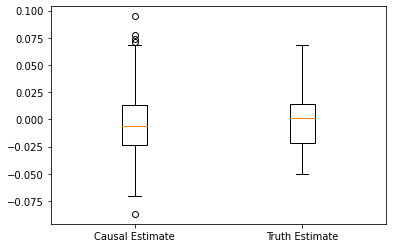

In [3]:
plt.boxplot([causal_estimates, truth_estimates])
labels = ['Causal Estimate', 'Truth Estimate']
plt.xticks(np.arange(len(labels))+1,labels)

## Estimating Longitudinal Causal Effects Under Hard Interventions

Generally, we expect that the true causal model would have non-zero causal effects, unlike the special case previously discussed. We briefly outline how estimation would normally proceed.

In the first instance, we might be interested in the outcome of a particular "hard" intervention.

We use a synthetic data generating process, where there exist true nonzero causal effects from the treatments $A_0, A_1$ to the outcome $Y$.

Identifying causal effects in the study depicted in  Figure 8 of the article corresponds to the following equation:

$$\mathbb{E}[Y(a_0, a_1)] = \sum_{l_0, l_1} \mathbb{E}[Y \mid A_0 =a_0, A_1 = a_1, L_0=l_0, L_1=l_1]  p(L_1 = l_1 | A_0 = a_0, L_0=l_0)p(L_0 = l_0)$$

where we can estimate the term on the left by estimating logistic regression models for each term on the right.

In [4]:
causal_estimates = []
truth_estimates = []
for i in range(50):
    df = data.generate_longitudinal_dataset(N=10000)
    df_0 = data.generate_longitudinal_dataset(N=5000, A0=0, A1=0)
    df_1 = data.generate_longitudinal_dataset(N=5000, A0=1, A1=1)

    p_1_1 = estimators.estimate_longitudinal_effect(data=df, 
                                                    intermediates=["L_0", "L_1"], 
                                                    treatments=["A_0", "A_1"], 
                                                    outcome="Y",
                                                   treatment_values=(1, 1))
    p_1_0 = estimators.estimate_longitudinal_effect(data=df, 
                                                    intermediates=["L_0", "L_1"], 
                                                    treatments=["A_0", "A_1"], 
                                                    outcome="Y",
                                                    treatment_values=(0, 0))

    causal_estimates.append(p_1_1 - p_1_0)
    truth_estimates.append(df_1["Y"].mean() - df_0["Y"].mean())

/home/intuitivecomputing/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/intuitivecomputing/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [5]:
plt.boxplot([causal_estimates, truth_estimates])
labels = ['Causal Estimate', 'Truth Estimate']
plt.xticks(np.arange(len(labels))+1,labels)

([<matplotlib.axis.XTick at 0x7fe9c60135b0>,
 [Text(1, 0, 'Causal Estimate'), Text(2, 0, 'Truth Estimate')])

## Estimating Longitudinal Causal Effects Under Policy Interventions

Often, when we devise rules about actions over time, these rules are not fixed. Having a robot perform a certain kind of action regardless of the environment is not a particularly realistic policy and may not work well in practice. What we want is to see how the robot would perform given a particular policy (a mechanism for choosing a next action based on the current history).

Let $g_0 = g_0 (A_0 | L_0)$ be the policy that chooses action $A_0$ given past intermediate outcome $L_0$, and $g_1 = g_1 (A_1 | L_1, A_0, L_0)$ to be the policy that chooses $A_1$ given history of past action $A_0$ and past intermediate outcomes $L_0, L_1$.
Then, the extended g-formula gives us:
$$\mathbb{E}[Y(g_0, g_1)] = \sum_{l_0, l_1} \mathbb{E}[Y \mid A_0 =a_0, A_1 = a_1, L_0=l_0, L_1=l_1] p(L_1 = l_1 | A_0 = a_0, L_0=l_0)p(L_0 = l_0) g_0 (A_0 | L_0) g_1 (A_1 | L_1, A_0, L_0)$$

For this example, we evaluate the outcome under the policies $g_0(A_0=1 | L_0) = expit(0.3 + L_0)$, and $g_1(A_1 =1 | L_0, L_1, A_0) = expit(0.3 + L_0 - 0.5 L_1 + 0.2 A_0)$, where $expit(x) = 1 / (1 + exp(-x))$.

In [6]:
class PolicyEstimatorA0(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def predict_proba(self, X):
        probs = []
        for i in range(X.shape[0]):
            p_1 = expit(0.3 + X[i, 0])
            p_0 = 1 - p_1
            probs.append([p_0, p_1])
        return np.array(probs)

class PolicyEstimatorA1(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        return self


    def predict_proba(self, X):
        probs = []
        for i in range(X.shape[0]):
            # L_0, L_1, A_0
            p_1 = expit(0.3 + X[i, 0] - 0.5 * X[i, 1] + 0.2 * X[i, 2])
            p_0 = 1 - p_1
            probs.append([p_0, p_1])
        return np.array(probs)

A0_model = PolicyEstimatorA0()
A1_model = PolicyEstimatorA1()

treatment_models = {
         "A_0": A0_model,
         "A_1": A1_model,
}
treatments = ["A_0", "A_1"]
intermediates = ["L_0", "L_1"]
outcome = "Y"
treatment_covariates = {"A_0": ["L_0"], "A_1": ["L_0", "A_0", "L_1"]}


causal_estimates = []
truth_estimates = []
for i in range(50):
    df = data.generate_longitudinal_dataset(N=10000)
    truth = data.generate_longitudinal_dataset(N=10000, policy_A0=A0_model, policy_A1=A1_model)
    result = estimators.estimate_longitudinal_policy_effect(
            data=df,
            treatments=treatments,
            intermediates=intermediates,
            outcome=outcome,
            treatment_models=treatment_models,
            treatment_covariates=treatment_covariates,
        )
    causal_estimates.append(result)
    truth_estimates.append(truth[outcome].mean())

/home/intuitivecomputing/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


To interpret the results, recall that we are comparing the causal estimate (where we have access to data collected under the old policy, and we want to evaluate the outcome under a new policy) versus the truth (where we generate data according to the new policy and observe the outcome). 

The results show that the causal estimate and the truth line up as expected. Furthermore, the new policy appears to increase the outcome value (improves the participant response) and therefore may be a candidate for further testing.

([<matplotlib.axis.XTick at 0x7fe9c63a8640>,
 [Text(1, 0, 'Causal Estimate'), Text(2, 0, 'Truth Estimate')])

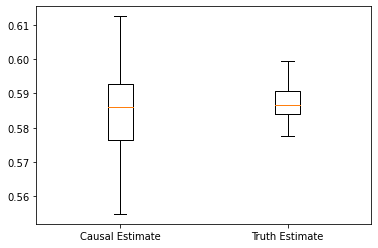

In [7]:
plt.boxplot([causal_estimates, truth_estimates])
labels = ['Causal Estimate', 'Truth Estimate']
plt.xticks(np.arange(len(labels))+1,labels)